# Importing Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
! pip install talos

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np, pandas as pd

!pip install Keras-Preprocessing


import re
import spacy
from spacy.lang.en import English
from spacy.lang.en.stop_words import STOP_WORDS
from nltk.tokenize import word_tokenize
import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
import string
from string import ascii_lowercase

from tqdm import tqdm_notebook
import itertools
import io

import matplotlib.pyplot as plt
%matplotlib inline

from functools import reduce
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D
from keras.layers import BatchNormalization
from keras import initializers, regularizers, constraints, optimizers, layers
import talos

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Importing Data

In [ ]:
train=pd.read_csv('/content/drive/MyDrive/train.csv/train.csv')
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [ ]:
test=pd.read_csv('/content/drive/MyDrive/test.csv/test.csv')
test.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


Data Exploration

Checking for missing values

In [ ]:
train.shape

(159571, 8)

In [ ]:
test.shape

(153164, 2)

In [ ]:
train.isnull().any()

id               False
comment_text     False
toxic            False
severe_toxic     False
obscene          False
threat           False
insult           False
identity_hate    False
dtype: bool

In [ ]:
test.isnull().any()

id              False
comment_text    False
dtype: bool

In [ ]:
Classification_labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
y = train[Classification_labels].values

Data Pre-processing

Text Normalization

In [ ]:
regex_patterns = {
    ' american ':
        [
            'amerikan'
        ],

    ' adolf ':
        [
            'adolf'
        ],


    ' hitler ':
        [
            'hitler'
        ],

    ' fuck':
        [
            '(f)(u|[^a-z0-9 ])(c|[^a-z0-9 ])(k|[^a-z0-9 ])([^ ])*',
            '(f)([^a-z]*)(u)([^a-z]*)(c)([^a-z]*)(k)',
            ' f[!@#\$%\^\&\*]*u[!@#\$%\^&\*]*k', 'f u u c',
            '(f)(c|[^a-z ])(u|[^a-z ])(k)', r'f\*',
            'feck ', ' fux ', 'f\*\*', 'f**k','fu*k',
            'f\-ing', 'f\.u\.', 'f###', ' fu ', 'f@ck', 'f u c k', 'f uck', 'f ck'
        ],

    ' ass ':
        [
            '[^a-z]ass ', '[^a-z]azz ', 'arrse', ' arse ', '@\$\$',
            '[^a-z]anus', ' a\*s\*s', '[^a-z]ass[^a-z ]',
            'a[@#\$%\^&\*][@#\$%\^&\*]', '[^a-z]anal ', 'a s s','a55', '@$$'
        ],

    ' ass hole ':
        [
            ' a[s|z]*wipe', 'a[s|z]*[w]*h[o|0]+[l]*e', '@\$\$hole', 'a**hole'
        ],

    ' bitch ':
        [
            'b[w]*i[t]*ch', 'b!tch',
            'bi\+ch', 'b!\+ch', '(b)([^a-z]*)(i)([^a-z]*)(t)([^a-z]*)(c)([^a-z]*)(h)',
            'biatch', 'bi\*\*h', 'bytch', 'b i t c h', 'b!tch', 'bi+ch', 'l3itch'
        ],

    ' bastard ':
        [
            'ba[s|z]+t[e|a]+rd'
        ],

    ' trans gender':
        [
            'transgender'
        ],

    ' gay ':
        [
            'gay'
        ],

    ' cock ':
        [
            '[^a-z]cock', 'c0ck', '[^a-z]cok ', 'c0k', '[^a-z]cok[^aeiou]', ' cawk',
            '(c)([^a-z ])(o)([^a-z ]*)(c)([^a-z ]*)(k)', 'c o c k'
        ],

    ' dick ':
        [
            ' dick[^aeiou]', 'deek', 'd i c k', 'dik'
        ],

    ' suck ':
        [
            'sucker', '(s)([^a-z ]*)(u)([^a-z ]*)(c)([^a-z ]*)(k)', 'sucks', '5uck', 's u c k'
        ],

    ' cunt ':
        [
            'cunt', 'c u n t'
        ],

    ' bull shit ':
        [
            'bullsh\*t', 'bull\$hit'
        ],

    ' homo sex ual':
        [
            'homosexual'
        ],

    ' jerk ':
        [
            'jerk'
        ],

    ' idiot ':
        [
            'i[d]+io[t]+', '(i)([^a-z ]*)(d)([^a-z ]*)(i)([^a-z ]*)(o)([^a-z ]*)(t)', 'idiots'
                                                                                      'i d i o t'
        ],

    ' dumb ':
        [
            '(d)([^a-z ]*)(u)([^a-z ]*)(m)([^a-z ]*)(b)'
        ],

    ' shit ':
        [
            'shitty', '(s)([^a-z ]*)(h)([^a-z ]*)(i)([^a-z ]*)(t)', 'shite', '\$hit', 's h i t', '$h1t'
        ],

    ' shit hole ':
        [
            'shythole'
        ],

    ' retard ':
        [
            'returd', 'retad', 'retard', 'wiktard', 'wikitud'
        ],

    ' rape ':
        [
            ' raped'
        ],

    ' dumb ass':
        [
            'dumbass', 'dubass'
        ],

    ' ass head':
        [
            'butthead'
        ],

    ' sex ':
        [
            'sexy', 's3x', 'sexuality'
        ],


    ' nigger ':
        [
            'nigger', 'ni[g]+a', ' nigr ', 'negrito', 'niguh', 'n3gr', 'n i g g e r'
        ],

    ' shut the fuck up':
        [
            'stfu', 'st*u'
        ],

    ' pussy ':
        [
            'pussy[^c]', 'pusy', 'pussi[^l]', 'pusses', 'p*ssy'
        ],

    ' faggot ':
        [
            'faggot', ' fa[g]+[s]*[^a-z ]', 'fagot', 'f a g g o t', 'faggit',
            '(f)([^a-z ]*)(a)([^a-z ]*)([g]+)([^a-z ]*)(o)([^a-z ]*)(t)', 'fau[g]+ot', 'fae[g]+ot',
        ],

    ' mother fucker':
        [
            ' motha ', ' motha f', ' mother f', 'motherucker',
        ],

    ' whore ':
        [
            'wh\*\*\*', 'w h o r e'
        ],
    ' fucking ':
        [
            'f*$%-ing'
        ],
}


In [ ]:
def clean_text(text,repeat_text=True, patterns_text=True, is_lower=True):

  if is_lower:
    text=text.lower()

  if patterns_text:
    for target, patterns in regex_patterns.items():
      for pat in patterns:
        text=str(text).replace(pat, target)

  if repeat_text:
    text = re.sub(r'(.)\1{2,}', r'\1', text)

  text = str(text).replace("\n", " ")
  text = re.sub(r'[^\w\s]',' ',text)
  text = re.sub('[0-9]',"",text)
  text = re.sub(" +", " ", text)
  text = re.sub("([^\x00-\x7F])+"," ",text)
  return text

Cleaning Training Data

In [ ]:
train['comment_text']=train['comment_text'].apply(lambda x: clean_text(x))
train['comment_text'][1]

'd aww he matches this background colour i m seemingly stuck with thanks talk january utc '

Cleaning Test Data

In [ ]:
test['comment_text']=test['comment_text'].apply(lambda x: clean_text(x))
test['comment_text'][1048]

'this is a university ip address just fyi '

Lemmatization

In [ ]:
comments_train=train['comment_text']
comments_test=test['comment_text']

In [ ]:
comments_train=list(comments_train)
comments_test=list(comments_test)

In [ ]:
wordnet_lemmatizer = WordNetLemmatizer()

In [ ]:
def lemma(text, lemmatization=True):
  output=""
  if lemmatization:
    text=text.split(" ")
    for word in text:
       word1 = wordnet_lemmatizer.lemmatize(word, pos = "n")
       word2 = wordnet_lemmatizer.lemmatize(word1, pos = "v")
       word3 = wordnet_lemmatizer.lemmatize(word2, pos = "a")
       word4 = wordnet_lemmatizer.lemmatize(word3, pos = "r")
       output=output + " " + word4
  else:
    output=text

  return str(output.strip())

Lemmatizing Training Data

In [ ]:
lem_train_data = []

for line in tqdm_notebook(comments_train, total=159571):
    lem_train_data.append(lemma(line))

  0%|          | 0/159571 [00:00<?, ?it/s]

In [ ]:
lem_train_data[152458]

'i agree with you about graemel s intention he be a revert nazi and wikipedia ha a way of protect against this report him to the wp rr three revert rule notice board post by report the revert nazi graemel ha show himself herself to be a revert nazi this be unacceptable on a site that be make by it s user and not it s admins if you feel you have be unjustly revert more than time over a hour period please report him her to the three revert noticeboard wp rr it be time to take back what be ours'

Lemmatizing Test Data

In [ ]:
lem_test_data = []

for line in tqdm_notebook(comments_test, total=len(comments_test)):
    lem_test_data.append(lemma(line))

  0%|          | 0/153164 [00:00<?, ?it/s]

Stopwords Removal

In [ ]:
Total_stopword=STOP_WORDS

# Removing Stopwords from Training Data

In [ ]:
def stopwords(text, rem_stop_wrds=True):
  output_text = ""
  if rem_stop_wrds:
    text=text.split(" ")
    for word in text:
      if word not in Total_stopword:
        output_text=output_text + " " + word
  else :
    output_text=text

  return str(output_text.strip())

In [ ]:
proc_train_data = []

for line in tqdm_notebook(lem_train_data, total=159571):
    proc_train_data.append(stopwords(line))

  0%|          | 0/159571 [00:00<?, ?it/s]

In [ ]:
proc_train_data[152458]

'agree graemel s intention revert nazi wikipedia ha way protect report wp rr revert rule notice board post report revert nazi graemel ha revert nazi unacceptable site s user s admins feel unjustly revert time hour period report revert noticeboard wp rr time'

Removing Stopwords from Test Data

In [ ]:
proc_test_data = []

for line in tqdm_notebook(lem_test_data, total=153164):
    proc_test_data.append(stopwords(line))

  0%|          | 0/153164 [00:00<?, ?it/s]

Model Building

In [ ]:
max_features=100000
maxpadlen = 200
val_split = 0.2
embed_dim_fasttext = 300

Tokenization

In [ ]:
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(proc_train_data))
list_tokenized_train = tokenizer.texts_to_sequences(proc_train_data)
list_tokenized_test = tokenizer.texts_to_sequences(proc_test_data)

In [ ]:
word_index=tokenizer.word_index
print("Words in Vocabulary: ",len(word_index))

Words in Vocabulary:  149326


Padding

In [ ]:
X_t=pad_sequences(list_tokenized_train, maxlen=maxpadlen, padding = 'post')
X_te=pad_sequences(list_tokenized_test, maxlen=maxpadlen, padding = 'post')

In [ ]:
print('Tokenized sentences: \n', X_t[10])
print('One hot label: \n', y[10])

Tokenized sentences: 
 [    2  1424   152     9    28   436     4     7    65   152     9   634
   232   152     9   211    81   119   635   152     9   634     4    29
    35    28     4     7   542   141    27  1162     6     4   452  1147
    28  2507   544    70   152     9    28   232   456   415    25   300
   232   286   189   145    44    46    62   211   112    46     4    15
     8   302  4722    14    28 32694   283    15   232    28 32694   283
   125   210     1   436     4   360   103     3   635    67    79   112
   473  1636    67   210    24   635  1347   112  1727   172    27   172
     5  4861   172     1   130     9    79   621  1333    39   112  1420
   156   172     1  1663   112  1211    18    14    18   562   112   485
    64   210   103     3    67   207  2308   501    64     9   363  1615
   105   211   279   189     6   152     9     9    64    64    35     6
    28   112    64   152     9     6    28   112    64    35   112    64
     9   232   210    81   1

In [ ]:
indices = np.arange(X_t.shape[0])
np.random.shuffle(indices)

In [ ]:
X_t = X_t[indices]
labels = y[indices]

Splitting data into Training and Validation Set

In [ ]:
num_val_samples = int(val_split*X_t.shape[0])
x_tr = X_t[: -num_val_samples]
y_tr = labels[: -num_val_samples]
x_val = X_t[-num_val_samples: ]
y_val = labels[-num_val_samples: ]

In [ ]:
print('Number of entries in each category:')
print('training entries: ', y_tr.sum(axis=0))
print('validation entries: ', y_val.sum(axis=0))

Number of entries in each category:
training entries:  [12227  1294  6712   381  6271  1112]
validation entries:  [3067  301 1737   97 1606  293]


Importing Fast tex

In [ ]:
embed_index_fasttext = {}
f = open('/content/drive/MyDrive/wiki-news-300d-1M.vec', encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    embed_index_fasttext[word] = np.asarray(values[1:], dtype='float32')
f.close()

In [ ]:
embed_matrix_fasttext = np.random.random((len(word_index) + 1, embed_dim_fasttext))
for word, i in word_index.items():
    embed_vector = embed_index_fasttext.get(word)
    if embed_vector is not None:
        embed_matrix_fasttext[i] = embed_vector
print(" Task Completed")

 Task Completed


Creating Model

Talos Grid Search for LSTM Model

In [ ]:
def toxic_comment_classifier(x_train,y_train,x_val,y_val,params):

  inp=Input(shape=(maxpadlen, ),dtype='int32')

  embedding_layer = Embedding(len(word_index) + 1,
                           embed_dim_fasttext,
                           weights = [embed_matrix_fasttext],
                           input_length = maxpadlen,
                           trainable=False,
                           name = 'embeddings')
  embedded_sequences = embedding_layer(inp)

  x = LSTM(params['output_count_lstm'], return_sequences=True,name='lstm_layer')(embedded_sequences)

  x = GlobalMaxPool1D()(x)

  x = Dropout(params['dropout'])(x)

  x = Dense(params['output_count_dense'], activation=params['activation'], kernel_initializer='he_uniform')(x)

  x = Dropout(params['dropout'])(x)

  preds = Dense(6, activation=params['last_activation'], kernel_initializer='glorot_uniform')(x)

  model = Model(inputs=inp, outputs=preds)

  model.compile(loss=params['loss'], optimizer=params['optimizer'], metrics=['accuracy'])

  model_info=model.fit(x_train,y_train, epochs=params['epochs'], batch_size=params['batch_size'],  validation_data=(x_val, y_val))

  return model_info, model

In [ ]:
p={
    'output_count_lstm': [40,50,60],
    'output_count_dense': [30,40,50],
    'batch_size': [32],
    'epochs':[2],
    'optimizer':['adam'],
    'activation':['relu'],
    'last_activation': ['sigmoid'],
    'dropout':[0.1,0.2],
    'loss': ['binary_crossentropy']
}

In [ ]:
drscan_results = talos.Scan(x=x_tr,
               y=y_tr,
               x_val=x_val,
               y_val=y_val,
               model=toxic_comment_classifier,
               params=p,
               experiment_name='tcc',
               print_params=True)

  0%|          | 0/18 [00:00<?, ?it/s]

{'output_count_lstm': 40, 'output_count_dense': 30, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.1, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 41s 9ms/step - loss: 0.0613 - accuracy: 0.9237 - val_loss: 0.0526 - val_accuracy: 0.9940
Epoch 2/2
3990/3990 [==============================] - 36s 9ms/step - loss: 0.0491 - accuracy: 0.9741 - val_loss: 0.0476 - val_accuracy: 0.9939


  6%|▌         | 1/18 [01:18<22:10, 78.29s/it]

{'output_count_lstm': 40, 'output_count_dense': 30, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.2, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 39s 9ms/step - loss: 0.0688 - accuracy: 0.8775 - val_loss: 0.0504 - val_accuracy: 0.9940
Epoch 2/2
3990/3990 [==============================] - 36s 9ms/step - loss: 0.0508 - accuracy: 0.9780 - val_loss: 0.0489 - val_accuracy: 0.9940


 11%|█         | 2/18 [02:34<20:35, 77.21s/it]

{'output_count_lstm': 40, 'output_count_dense': 40, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.1, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 39s 9ms/step - loss: 0.0641 - accuracy: 0.9390 - val_loss: 0.0493 - val_accuracy: 0.9940
Epoch 2/2
3990/3990 [==============================] - 36s 9ms/step - loss: 0.0491 - accuracy: 0.9888 - val_loss: 0.0470 - val_accuracy: 0.9938


 17%|█▋        | 3/18 [03:51<19:14, 76.99s/it]

{'output_count_lstm': 40, 'output_count_dense': 40, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.2, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 39s 9ms/step - loss: 0.0660 - accuracy: 0.9117 - val_loss: 0.0507 - val_accuracy: 0.9940
Epoch 2/2
3990/3990 [==============================] - 36s 9ms/step - loss: 0.0505 - accuracy: 0.9827 - val_loss: 0.0485 - val_accuracy: 0.9940


 22%|██▏       | 4/18 [05:08<17:57, 76.93s/it]

{'output_count_lstm': 40, 'output_count_dense': 50, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.1, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 40s 9ms/step - loss: 0.0623 - accuracy: 0.9523 - val_loss: 0.0510 - val_accuracy: 0.9940
Epoch 2/2
3990/3990 [==============================] - 36s 9ms/step - loss: 0.0487 - accuracy: 0.9874 - val_loss: 0.0501 - val_accuracy: 0.9934


 28%|██▊       | 5/18 [06:25<16:42, 77.09s/it]

{'output_count_lstm': 40, 'output_count_dense': 50, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.2, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 40s 9ms/step - loss: 0.0665 - accuracy: 0.9083 - val_loss: 0.0507 - val_accuracy: 0.9940
Epoch 2/2
3990/3990 [==============================] - 36s 9ms/step - loss: 0.0510 - accuracy: 0.9871 - val_loss: 0.0481 - val_accuracy: 0.9940


 33%|███▎      | 6/18 [07:43<15:26, 77.21s/it]

{'output_count_lstm': 50, 'output_count_dense': 30, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.1, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 44s 10ms/step - loss: 0.0647 - accuracy: 0.9265 - val_loss: 0.0501 - val_accuracy: 0.9940
Epoch 2/2
3990/3990 [==============================] - 41s 10ms/step - loss: 0.0491 - accuracy: 0.9914 - val_loss: 0.0472 - val_accuracy: 0.9936


 39%|███▉      | 7/18 [09:08<14:38, 79.89s/it]

{'output_count_lstm': 50, 'output_count_dense': 30, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.2, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 44s 10ms/step - loss: 0.0649 - accuracy: 0.9368 - val_loss: 0.0499 - val_accuracy: 0.9940
Epoch 2/2
3990/3990 [==============================] - 40s 10ms/step - loss: 0.0503 - accuracy: 0.9878 - val_loss: 0.0479 - val_accuracy: 0.9940


 44%|████▍     | 8/18 [10:33<13:36, 81.64s/it]

{'output_count_lstm': 50, 'output_count_dense': 40, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.1, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 44s 10ms/step - loss: 0.0615 - accuracy: 0.9377 - val_loss: 0.0505 - val_accuracy: 0.9940
Epoch 2/2
3990/3990 [==============================] - 41s 10ms/step - loss: 0.0482 - accuracy: 0.9760 - val_loss: 0.0472 - val_accuracy: 0.9933


 50%|█████     | 9/18 [11:59<12:25, 82.82s/it]

{'output_count_lstm': 50, 'output_count_dense': 40, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.2, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 44s 10ms/step - loss: 0.0628 - accuracy: 0.9472 - val_loss: 0.0504 - val_accuracy: 0.9940
Epoch 2/2
3990/3990 [==============================] - 41s 10ms/step - loss: 0.0503 - accuracy: 0.9901 - val_loss: 0.0477 - val_accuracy: 0.9940


 56%|█████▌    | 10/18 [13:24<11:09, 83.64s/it]

{'output_count_lstm': 50, 'output_count_dense': 50, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.1, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 44s 10ms/step - loss: 0.0605 - accuracy: 0.9557 - val_loss: 0.0488 - val_accuracy: 0.9939
Epoch 2/2
3990/3990 [==============================] - 40s 10ms/step - loss: 0.0477 - accuracy: 0.9900 - val_loss: 0.0465 - val_accuracy: 0.9936


 61%|██████    | 11/18 [14:50<09:49, 84.20s/it]

{'output_count_lstm': 50, 'output_count_dense': 50, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.2, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 44s 10ms/step - loss: 0.0641 - accuracy: 0.8977 - val_loss: 0.0503 - val_accuracy: 0.9940
Epoch 2/2
3990/3990 [==============================] - 40s 10ms/step - loss: 0.0498 - accuracy: 0.9562 - val_loss: 0.0475 - val_accuracy: 0.9939


 67%|██████▋   | 12/18 [16:15<08:27, 84.58s/it]

{'output_count_lstm': 60, 'output_count_dense': 30, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.1, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 40s 9ms/step - loss: 0.0617 - accuracy: 0.9100 - val_loss: 0.0495 - val_accuracy: 0.9940
Epoch 2/2
3990/3990 [==============================] - 37s 9ms/step - loss: 0.0488 - accuracy: 0.9682 - val_loss: 0.0490 - val_accuracy: 0.9935


 72%|███████▏  | 13/18 [17:33<06:53, 82.61s/it]

{'output_count_lstm': 60, 'output_count_dense': 30, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.2, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 40s 9ms/step - loss: 0.0671 - accuracy: 0.8943 - val_loss: 0.0499 - val_accuracy: 0.9940
Epoch 2/2
3990/3990 [==============================] - 37s 9ms/step - loss: 0.0508 - accuracy: 0.9861 - val_loss: 0.0479 - val_accuracy: 0.9940


 78%|███████▊  | 14/18 [18:51<05:24, 81.17s/it]

{'output_count_lstm': 60, 'output_count_dense': 40, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.1, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 40s 9ms/step - loss: 0.0603 - accuracy: 0.9572 - val_loss: 0.0503 - val_accuracy: 0.9939
Epoch 2/2
3990/3990 [==============================] - 37s 9ms/step - loss: 0.0482 - accuracy: 0.9866 - val_loss: 0.0470 - val_accuracy: 0.9937


 83%|████████▎ | 15/18 [20:09<04:00, 80.27s/it]

{'output_count_lstm': 60, 'output_count_dense': 40, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.2, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 40s 9ms/step - loss: 0.0642 - accuracy: 0.9020 - val_loss: 0.0499 - val_accuracy: 0.9940
Epoch 2/2
3990/3990 [==============================] - 37s 9ms/step - loss: 0.0494 - accuracy: 0.9894 - val_loss: 0.0487 - val_accuracy: 0.9933


 89%|████████▉ | 16/18 [21:27<02:39, 79.57s/it]

{'output_count_lstm': 60, 'output_count_dense': 50, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.1, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 40s 9ms/step - loss: 0.0610 - accuracy: 0.9221 - val_loss: 0.0500 - val_accuracy: 0.9934
Epoch 2/2
3990/3990 [==============================] - 37s 9ms/step - loss: 0.0476 - accuracy: 0.9726 - val_loss: 0.0467 - val_accuracy: 0.9929


 94%|█████████▍| 17/18 [22:46<01:19, 79.21s/it]

{'output_count_lstm': 60, 'output_count_dense': 50, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.2, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 40s 9ms/step - loss: 0.0648 - accuracy: 0.9091 - val_loss: 0.0535 - val_accuracy: 0.9940
Epoch 2/2
3990/3990 [==============================] - 37s 9ms/step - loss: 0.0494 - accuracy: 0.9713 - val_loss: 0.0469 - val_accuracy: 0.9939


100%|██████████| 18/18 [24:04<00:00, 80.23s/it]


In [ ]:
model_id = drscan_results.data['val_accuracy'].astype('float').argmax()
model_id

1

In [ ]:
analyze_object = talos.Analyze(drscan_results)

In [ ]:
analyze_object.best_params('val_accuracy', ['accuracy', 'loss', 'val_loss'])

array([[2, 'relu', 'adam', 2, 'sigmoid', 50, 32, 0.2, 40,
        84.72498869895935, '04/13/23-015440', '04/13/23-015605', 0],
       [2, 'relu', 'adam', 2, 'sigmoid', 50, 32, 0.2, 30,
        84.65039801597595, '04/13/23-015149', '04/13/23-015314', 1],
       [2, 'relu', 'adam', 2, 'sigmoid', 60, 32, 0.2, 30,
        77.08593368530273, '04/13/23-020014', '04/13/23-020131', 2],
       [2, 'relu', 'adam', 2, 'sigmoid', 40, 32, 0.2, 40,
        76.12564587593079, '04/13/23-014632', '04/13/23-014748', 3],
       [2, 'relu', 'adam', 2, 'sigmoid', 40, 32, 0.2, 30,
        75.74578595161438, '04/13/23-014359', '04/13/23-014515', 4],
       [2, 'relu', 'adam', 2, 'sigmoid', 40, 32, 0.2, 50,
        76.6955451965332, '04/13/23-014906', '04/13/23-015023', 5],
       [2, 'relu', 'adam', 2, 'sigmoid', 60, 32, 0.2, 50,
        77.1970705986023, '04/13/23-020527', '04/13/23-020644', 6],
       [2, 'relu', 'adam', 2, 'sigmoid', 50, 32, 0.2, 50,
        84.70613956451416, '04/13/23-015731', '04/13/23

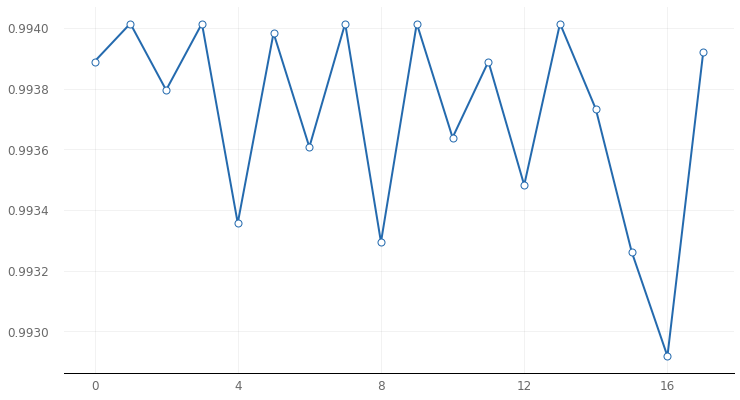

In [ ]:
analyze_object.plot_line('val_accuracy')

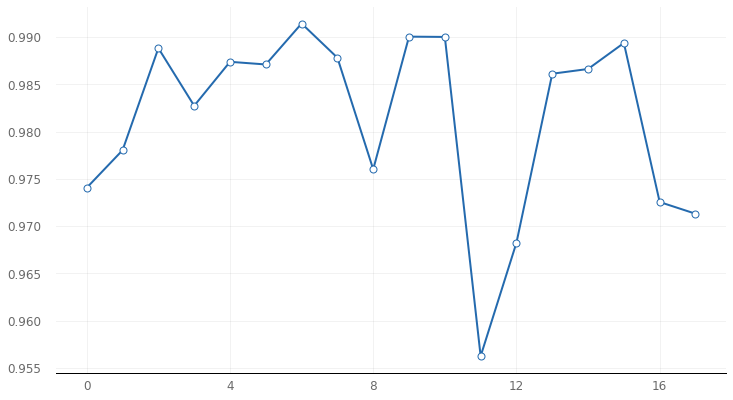

In [ ]:
analyze_object.plot_line('accuracy')

Talos Grid Search for LSTM-CNN Model

In [ ]:
def toxic_classifier(x_train,y_train,x_val,y_val,params):

  inp=Input(shape=(maxpadlen, ),dtype='int32')

  embedding_layer = Embedding(len(word_index) + 1,
                           embed_dim_fasttext,
                           weights = [embed_matrix_fasttext],
                           input_length = maxpadlen,
                           trainable=False,
                           name = 'embeddings')
  embedded_sequences = embedding_layer(inp)

  x = LSTM(params['output_count_lstm'], return_sequences=True,name='lstm_layer')(embedded_sequences)

  x = Conv1D(filters=params['filters'], kernel_size=params['kernel_size'], padding='same', activation='relu', kernel_initializer='he_uniform')(x)

  x = MaxPooling1D(params['pool_size'])(x)

  x = GlobalMaxPool1D()(x)

  x = BatchNormalization()(x)

  x = Dense(params['output_1_count_dense'], activation=params['activation'], kernel_initializer='he_uniform')(x)

  x = Dropout(params['dropout'])(x)

  x = Dense(params['output_2_count_dense'], activation=params['activation'], kernel_initializer='he_uniform')(x)

  x = Dropout(params['dropout'])(x)

  preds = Dense(6, activation=params['last_activation'], kernel_initializer='glorot_uniform')(x)

  model = Model(inputs=inp, outputs=preds)

  model.compile(loss=params['loss'], optimizer=params['optimizer'], metrics=['accuracy'])

  model_info=model.fit(x_train,y_train, epochs=params['epochs'], batch_size=params['batch_size'],  validation_data=(x_val, y_val))

  return model_info, model

In [ ]:
p={
    'output_count_lstm': [50,60],
    'output_1_count_dense': [40,50],
    'output_2_count_dense': [30,40],
    'filters' : [64],
    'kernel_size' : [3],
    'batch_size': [32],
    'pool_size': [3],
    'epochs':[2],
    'optimizer':['adam'],
    'activation':['relu'],
    'last_activation': ['sigmoid'],
    'dropout':[0.1,0.2],
    'loss': ['binary_crossentropy']
}

In [ ]:
scan_results = talos.Scan(x=x_tr,
               y=y_tr,
               x_val=x_val,
               y_val=y_val,
               model=toxic_classifier,
               params=p,
               experiment_name='tcc',
               print_params=True)

  0%|          | 0/16 [00:00<?, ?it/s]

{'output_count_lstm': 50, 'output_1_count_dense': 40, 'output_2_count_dense': 30, 'filters': 64, 'kernel_size': 3, 'batch_size': 32, 'pool_size': 3, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.1, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 51s 12ms/step - loss: 0.0687 - accuracy: 0.8405 - val_loss: 0.0524 - val_accuracy: 0.9931
Epoch 2/2
3990/3990 [==============================] - 46s 11ms/step - loss: 0.0523 - accuracy: 0.9809 - val_loss: 0.0600 - val_accuracy: 0.9940


  6%|▋         | 1/16 [01:37<24:27, 97.85s/it]

{'output_count_lstm': 50, 'output_1_count_dense': 40, 'output_2_count_dense': 30, 'filters': 64, 'kernel_size': 3, 'batch_size': 32, 'pool_size': 3, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.2, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 50s 12ms/step - loss: 0.0713 - accuracy: 0.8901 - val_loss: 0.0551 - val_accuracy: 0.9940
Epoch 2/2
3990/3990 [==============================] - 45s 11ms/step - loss: 0.0542 - accuracy: 0.9912 - val_loss: 0.0509 - val_accuracy: 0.9940


 12%|█▎        | 2/16 [03:14<22:38, 97.06s/it]

{'output_count_lstm': 50, 'output_1_count_dense': 40, 'output_2_count_dense': 40, 'filters': 64, 'kernel_size': 3, 'batch_size': 32, 'pool_size': 3, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.1, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 49s 11ms/step - loss: 0.0648 - accuracy: 0.9218 - val_loss: 0.0532 - val_accuracy: 0.9937
Epoch 2/2
3990/3990 [==============================] - 45s 11ms/step - loss: 0.0523 - accuracy: 0.9842 - val_loss: 0.0573 - val_accuracy: 0.9884


 19%|█▉        | 3/16 [04:49<20:52, 96.37s/it]

{'output_count_lstm': 50, 'output_1_count_dense': 40, 'output_2_count_dense': 40, 'filters': 64, 'kernel_size': 3, 'batch_size': 32, 'pool_size': 3, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.2, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 49s 11ms/step - loss: 0.0696 - accuracy: 0.8706 - val_loss: 0.0520 - val_accuracy: 0.9940
Epoch 2/2
3990/3990 [==============================] - 45s 11ms/step - loss: 0.0532 - accuracy: 0.9879 - val_loss: 0.0488 - val_accuracy: 0.9937


 25%|██▌       | 4/16 [06:25<19:12, 96.04s/it]

{'output_count_lstm': 50, 'output_1_count_dense': 50, 'output_2_count_dense': 30, 'filters': 64, 'kernel_size': 3, 'batch_size': 32, 'pool_size': 3, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.1, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 49s 11ms/step - loss: 0.0655 - accuracy: 0.8709 - val_loss: 0.0679 - val_accuracy: 0.9940
Epoch 2/2
3990/3990 [==============================] - 45s 11ms/step - loss: 0.0523 - accuracy: 0.9804 - val_loss: 0.0567 - val_accuracy: 0.9940


 31%|███▏      | 5/16 [08:01<17:35, 95.99s/it]

{'output_count_lstm': 50, 'output_1_count_dense': 50, 'output_2_count_dense': 30, 'filters': 64, 'kernel_size': 3, 'batch_size': 32, 'pool_size': 3, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.2, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 49s 11ms/step - loss: 0.0680 - accuracy: 0.8958 - val_loss: 0.0586 - val_accuracy: 0.9940
Epoch 2/2
3990/3990 [==============================] - 45s 11ms/step - loss: 0.0533 - accuracy: 0.9846 - val_loss: 0.0509 - val_accuracy: 0.9940


 38%|███▊      | 6/16 [09:37<15:59, 95.93s/it]

{'output_count_lstm': 50, 'output_1_count_dense': 50, 'output_2_count_dense': 40, 'filters': 64, 'kernel_size': 3, 'batch_size': 32, 'pool_size': 3, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.1, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 49s 11ms/step - loss: 0.0656 - accuracy: 0.9349 - val_loss: 0.0532 - val_accuracy: 0.9926
Epoch 2/2
3990/3990 [==============================] - 45s 11ms/step - loss: 0.0515 - accuracy: 0.9888 - val_loss: 0.0495 - val_accuracy: 0.9922


 44%|████▍     | 7/16 [11:12<14:22, 95.84s/it]

{'output_count_lstm': 50, 'output_1_count_dense': 50, 'output_2_count_dense': 40, 'filters': 64, 'kernel_size': 3, 'batch_size': 32, 'pool_size': 3, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.2, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 49s 11ms/step - loss: 0.0691 - accuracy: 0.9148 - val_loss: 0.0544 - val_accuracy: 0.9940
Epoch 2/2
3990/3990 [==============================] - 45s 11ms/step - loss: 0.0537 - accuracy: 0.9807 - val_loss: 0.0516 - val_accuracy: 0.9930


 50%|█████     | 8/16 [12:48<12:47, 95.93s/it]

{'output_count_lstm': 60, 'output_1_count_dense': 40, 'output_2_count_dense': 30, 'filters': 64, 'kernel_size': 3, 'batch_size': 32, 'pool_size': 3, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.1, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 47s 11ms/step - loss: 0.0638 - accuracy: 0.8884 - val_loss: 0.0565 - val_accuracy: 0.9934
Epoch 2/2
3990/3990 [==============================] - 43s 11ms/step - loss: 0.0519 - accuracy: 0.9591 - val_loss: 0.0512 - val_accuracy: 0.9831


 56%|█████▋    | 9/16 [14:20<11:01, 94.56s/it]

{'output_count_lstm': 60, 'output_1_count_dense': 40, 'output_2_count_dense': 30, 'filters': 64, 'kernel_size': 3, 'batch_size': 32, 'pool_size': 3, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.2, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 47s 11ms/step - loss: 0.0767 - accuracy: 0.8913 - val_loss: 0.0563 - val_accuracy: 0.9940
Epoch 2/2
3990/3990 [==============================] - 43s 11ms/step - loss: 0.0547 - accuracy: 0.9838 - val_loss: 0.0510 - val_accuracy: 0.9940


 62%|██████▎   | 10/16 [15:51<09:21, 93.54s/it]

{'output_count_lstm': 60, 'output_1_count_dense': 40, 'output_2_count_dense': 40, 'filters': 64, 'kernel_size': 3, 'batch_size': 32, 'pool_size': 3, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.1, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 47s 11ms/step - loss: 0.0642 - accuracy: 0.9379 - val_loss: 0.0518 - val_accuracy: 0.9940
Epoch 2/2
3990/3990 [==============================] - 43s 11ms/step - loss: 0.0518 - accuracy: 0.9803 - val_loss: 0.0493 - val_accuracy: 0.9940


 69%|██████▉   | 11/16 [17:23<07:44, 92.86s/it]

{'output_count_lstm': 60, 'output_1_count_dense': 40, 'output_2_count_dense': 40, 'filters': 64, 'kernel_size': 3, 'batch_size': 32, 'pool_size': 3, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.2, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 47s 11ms/step - loss: 0.0693 - accuracy: 0.8994 - val_loss: 0.0586 - val_accuracy: 0.9940
Epoch 2/2
3990/3990 [==============================] - 43s 11ms/step - loss: 0.0537 - accuracy: 0.9663 - val_loss: 0.0515 - val_accuracy: 0.9940


 75%|███████▌  | 12/16 [18:54<06:09, 92.42s/it]

{'output_count_lstm': 60, 'output_1_count_dense': 50, 'output_2_count_dense': 30, 'filters': 64, 'kernel_size': 3, 'batch_size': 32, 'pool_size': 3, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.1, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 47s 11ms/step - loss: 0.0648 - accuracy: 0.8923 - val_loss: 0.0634 - val_accuracy: 0.9937
Epoch 2/2
3990/3990 [==============================] - 43s 11ms/step - loss: 0.0515 - accuracy: 0.9697 - val_loss: 0.0566 - val_accuracy: 0.9937


 81%|████████▏ | 13/16 [20:25<04:36, 92.10s/it]

{'output_count_lstm': 60, 'output_1_count_dense': 50, 'output_2_count_dense': 30, 'filters': 64, 'kernel_size': 3, 'batch_size': 32, 'pool_size': 3, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.2, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 47s 11ms/step - loss: 0.0733 - accuracy: 0.9129 - val_loss: 0.0553 - val_accuracy: 0.9940
Epoch 2/2
3990/3990 [==============================] - 43s 11ms/step - loss: 0.0541 - accuracy: 0.9844 - val_loss: 0.0550 - val_accuracy: 0.9939


 88%|████████▊ | 14/16 [21:56<03:03, 91.82s/it]

{'output_count_lstm': 60, 'output_1_count_dense': 50, 'output_2_count_dense': 40, 'filters': 64, 'kernel_size': 3, 'batch_size': 32, 'pool_size': 3, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.1, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 47s 11ms/step - loss: 0.0656 - accuracy: 0.8922 - val_loss: 0.0542 - val_accuracy: 0.9927
Epoch 2/2
3990/3990 [==============================] - 43s 11ms/step - loss: 0.0512 - accuracy: 0.9827 - val_loss: 0.0483 - val_accuracy: 0.9918


 94%|█████████▍| 15/16 [23:28<01:31, 91.66s/it]

{'output_count_lstm': 60, 'output_1_count_dense': 50, 'output_2_count_dense': 40, 'filters': 64, 'kernel_size': 3, 'batch_size': 32, 'pool_size': 3, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.2, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 47s 11ms/step - loss: 0.0687 - accuracy: 0.8907 - val_loss: 0.0617 - val_accuracy: 0.9940
Epoch 2/2
3990/3990 [==============================] - 43s 11ms/step - loss: 0.0531 - accuracy: 0.9733 - val_loss: 0.0497 - val_accuracy: 0.9939


100%|██████████| 16/16 [24:59<00:00, 93.73s/it]


In [ ]:
model_id = scan_results.data['val_accuracy'].astype('float').argmax()
model_id

5

In [ ]:
scan_results.data[8:9]

,start,end,duration,round_epochs,loss,accuracy,val_loss,val_accuracy,output_count_lstm,output_1_count_dense,...,filters,kernel_size,batch_size,pool_size,epochs,optimizer,activation,last_activation,dropout,loss
8,04/13/23-021934,04/13/23-022105,90.748007,2,0.051883,0.959094,0.051204,0.98308,60,40,...,64,3,32,3,2,adam,relu,sigmoid,0.1,binary_crossentropy


In [ ]:
analyze_object = talos.Analyze(scan_results)

In [ ]:
analyze_object.best_params('val_accuracy', ['accuracy', 'loss', 'val_loss'])

array([[50, 30, 2, 64, 'relu', 'adam', 2, 'sigmoid', 50, 32, 0.2, 3, 3,
        95.05584692955017, '04/13/23-021447', '04/13/23-021622', 0],
       [40, 30, 2, 64, 'relu', 'adam', 2, 'sigmoid', 50, 32, 0.1, 3, 3,
        97.07203888893127, '04/13/23-020646', '04/13/23-020823', 1],
       [40, 30, 2, 64, 'relu', 'adam', 2, 'sigmoid', 50, 32, 0.2, 3, 3,
        95.71878838539124, '04/13/23-020823', '04/13/23-020959', 2],
       [40, 30, 2, 64, 'relu', 'adam', 2, 'sigmoid', 60, 32, 0.2, 3, 3,
        90.46193671226501, '04/13/23-022106', '04/13/23-022236', 3],
       [40, 40, 2, 64, 'relu', 'adam', 2, 'sigmoid', 60, 32, 0.2, 3, 3,
        90.63142323493958, '04/13/23-022409', '04/13/23-022539', 4],
       [50, 30, 2, 64, 'relu', 'adam', 2, 'sigmoid', 50, 32, 0.1, 3, 3,
        95.10349988937378, '04/13/23-021311', '04/13/23-021446', 5],
       [40, 40, 2, 64, 'relu', 'adam', 2, 'sigmoid', 60, 32, 0.1, 3, 3,
        90.5139172077179, '04/13/23-022237', '04/13/23-022408', 6],
       [50, 30

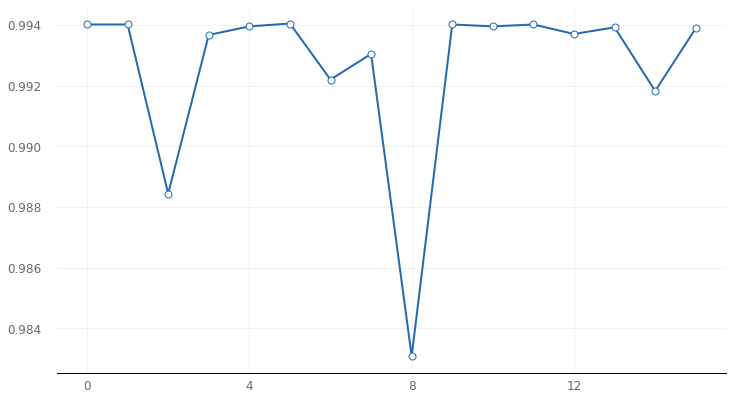

In [ ]:
analyze_object.plot_line('val_accuracy')

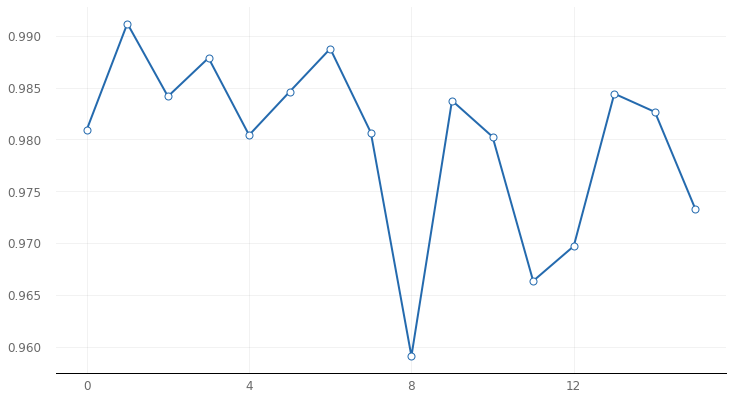

In [ ]:
analyze_object.plot_line('accuracy')

Training Model with Best Parameters

LSTM

In [ ]:
inp=Input(shape=(maxpadlen, ),dtype='int32')

In [ ]:
embedding_layer = Embedding(len(word_index) + 1,
                           embed_dim_fasttext,
                           weights = [embed_matrix_fasttext],
                           input_length = maxpadlen,
                           trainable=False,
                           name = 'embeddings')
embedded_sequences = embedding_layer(inp)

In [ ]:
x = LSTM(40, return_sequences=True,name='lstm_layer')(embedded_sequences)
x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
x = Dense(30, activation="relu", kernel_initializer='he_uniform')(x)
x = Dropout(0.1)(x)
preds = Dense(6, activation="sigmoid", kernel_initializer='glorot_uniform')(x)

In [ ]:
model_1 = Model(inputs=inp, outputs=preds)
model_1.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

In [ ]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200)]             0         
                                                                 
 embeddings (Embedding)      (None, 200, 300)          44798100  
                                                                 
 lstm_layer (LSTM)           (None, 200, 40)           54560     
                                                                 
 global_max_pooling1d (Globa  (None, 40)               0         
 lMaxPooling1D)                                                  
                                                                 
 dropout (Dropout)           (None, 40)                0         
                                                                 
 dense (Dense)               (None, 30)                1230      
                                                             

In [ ]:
model_info_1=model_1.fit(x_tr,y_tr, epochs=2, batch_size=32,  validation_data=(x_val, y_val))

Epoch 1/2
3990/3990 [==============================] - 40s 9ms/step - loss: 0.0642 - accuracy: 0.9105 - val_loss: 0.0512 - val_accuracy: 0.9940
Epoch 2/2
3990/3990 [==============================] - 37s 9ms/step - loss: 0.0497 - accuracy: 0.9824 - val_loss: 0.0487 - val_accuracy: 0.9935


LSTM-CNN

In [ ]:
inp=Input(shape=(maxpadlen, ),dtype='int32')

In [ ]:
embedding_layer = Embedding(len(word_index) + 1,
                           embed_dim_fasttext,
                           weights = [embed_matrix_fasttext],
                           input_length = maxpadlen,
                           trainable=False,
                           name = 'embeddings')
embedded_sequences = embedding_layer(inp)

In [ ]:
x = LSTM(50, return_sequences=True,name='lstm_layer')(embedded_sequences)
x = Conv1D(filters=64, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_uniform')(x)
x = MaxPooling1D(3)(x)
x = GlobalMaxPool1D()(x)
x = BatchNormalization()(x)
x = Dense(40, activation="relu", kernel_initializer='he_uniform')(x)
x = Dropout(0.2)(x)
x = Dense(30, activation="relu", kernel_initializer='he_uniform')(x)
x = Dropout(0.2)(x)
preds = Dense(6, activation="sigmoid", kernel_initializer='glorot_uniform')(x)

In [ ]:
model_2 = Model(inputs=inp, outputs=preds)
model_2.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

In [ ]:
model_2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 200)]             0         
                                                                 
 embeddings (Embedding)      (None, 200, 300)          44798100  
                                                                 
 lstm_layer (LSTM)           (None, 200, 50)           70200     
                                                                 
 conv1d (Conv1D)             (None, 200, 64)           9664      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 66, 64)           0         
 )                                                               
                                                                 
 global_max_pooling1d_1 (Glo  (None, 64)               0         
 balMaxPooling1D)                                          

In [ ]:
model_info_2=model_2.fit(x_tr,y_tr, epochs=2, batch_size=32,  validation_data=(x_val, y_val))

Epoch 1/2
3990/3990 [==============================] - 49s 11ms/step - loss: 0.0697 - accuracy: 0.8823 - val_loss: 0.0547 - val_accuracy: 0.9940
Epoch 2/2
3990/3990 [==============================] - 45s 11ms/step - loss: 0.0544 - accuracy: 0.9842 - val_loss: 0.0517 - val_accuracy: 0.9940


Plotting Graphs

LSTM

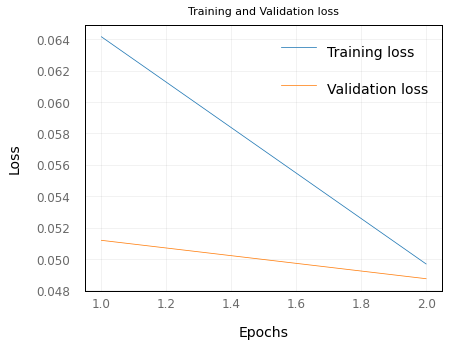

In [ ]:
loss = model_info_1.history['loss']
val_loss = model_info_1.history['val_loss']

epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show();

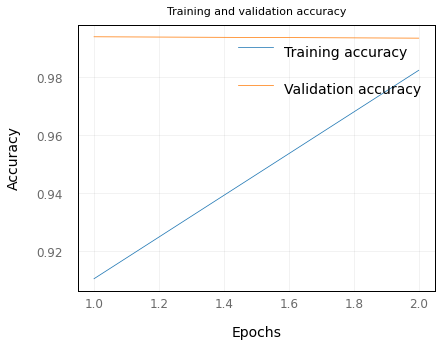

In [ ]:
accuracy = model_info_1.history['accuracy']
val_accuracy = model_info_1.history['val_accuracy']

plt.plot(epochs, accuracy, label='Training accuracy')
plt.plot(epochs, val_accuracy, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show();

LSTM-CNN

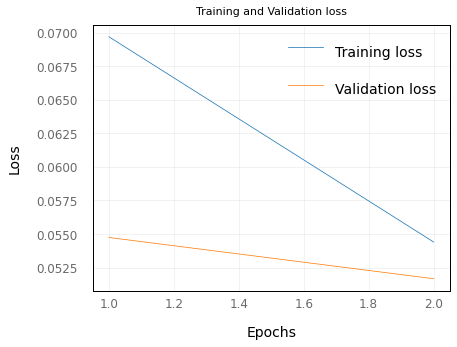

In [ ]:
loss = model_info_2.history['loss']
val_loss = model_info_2.history['val_loss']

epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show();

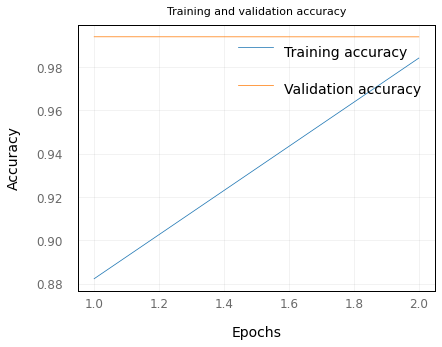

In [ ]:
accuracy = model_info_2.history['accuracy']
val_accuracy = model_info_2.history['val_accuracy']

plt.plot(epochs, accuracy, label='Training accuracy')
plt.plot(epochs, val_accuracy, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show();

Saving the model

In [ ]:
model_1.save(filepath="/content/model1.h5")

In [ ]:
model_2.save(filepath="/content/model2.h5")

Loading saved model

In [ ]:
loaded_model_1 = keras.models.load_model(filepath="/content/model1.h5")

In [ ]:
loaded_model_2 = keras.models.load_model(filepath="/content/model2.h5")

Generating the output

LSTM

In [ ]:
test_values_1 = loaded_model_1.predict([X_te], batch_size=1, verbose=1)

153164/153164 [==============================] - 507s 3ms/step


In [ ]:
sample_submission = pd.read_csv('/content/drive/MyDrive/test.csv/test.csv')
test_values_1=pd.DataFrame(test_values_1,columns=['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'])
submission = pd.DataFrame(sample_submission["id"])
combined_submission=pd.concat([submission,test_values_1],axis=1)
combined_submission.to_csv('/content/drive/MyDrive/Submission_LSTM.csv', index=False)

LSTM-CNN

In [ ]:
test_values_2 = loaded_model_2.predict([X_te], batch_size=1, verbose=1)

153164/153164 [==============================] - 546s 4ms/step


In [ ]:
sample_submission = pd.read_csv('/content/drive/MyDrive/test.csv/test.csv')
test_values_2=pd.DataFrame(test_values_2,columns=['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'])
submission = pd.DataFrame(sample_submission["id"])
combined_submission=pd.concat([submission,test_values_2],axis=1)
combined_submission.to_csv('/content/drive/MyDrive/Submission_CNN.csv', index=False)

Testing the created model

In [ ]:
def toxicity_level(string):
    new_string = [string]
    new_string = tokenizer.texts_to_sequences(new_string)
    new_string = pad_sequences(new_string, maxlen=maxpadlen, padding='post')

    prediction = model_1.predict(new_string)

    print("Toxicity levels for '{}':".format(string))
    print('Toxic:         {:.0%}'.format(prediction[0][0]))
    print('Severe Toxic:  {:.0%}'.format(prediction[0][1]))
    print('Obscene:       {:.0%}'.format(prediction[0][2]))
    print('Threat:        {:.0%}'.format(prediction[0][3]))
    print('Insult:        {:.0%}'.format(prediction[0][4]))
    print('Identity Hate: {:.0%}'.format(prediction[0][5]))
    print()

    return

In [ ]:
toxicity_level('go jump off a bridge jerk')

1/1 [==============================] - 0s 479ms/step
Toxicity levels for 'go jump off a bridge jerk':
Toxic:         89%
Severe Toxic:  5%
Obscene:       64%
Threat:        2%
Insult:        54%
Identity Hate: 2%



In [ ]:
toxicity_level('i will kill you')

1/1 [==============================] - 0s 32ms/step
Toxicity levels for 'i will kill you':
Toxic:         42%
Severe Toxic:  0%
Obscene:       4%
Threat:        4%
Insult:        12%
Identity Hate: 3%



In [ ]:
def toxicity_level_2(string):
    new_string = [string]
    new_string = tokenizer.texts_to_sequences(new_string)
    new_string = pad_sequences(new_string, maxlen=maxpadlen, padding='post')

    prediction = model_2.predict(new_string)

    print("Toxicity levels for '{}':".format(string))
    print('Toxic:         {:.0%}'.format(prediction[0][0]))
    print('Severe Toxic:  {:.0%}'.format(prediction[0][1]))
    print('Obscene:       {:.0%}'.format(prediction[0][2]))
    print('Threat:        {:.0%}'.format(prediction[0][3]))
    print('Insult:        {:.0%}'.format(prediction[0][4]))
    print('Identity Hate: {:.0%}'.format(prediction[0][5]))
    print()

    return

In [ ]:
toxicity_level_2('go jump off a bridge jerk')

1/1 [==============================] - 1s 1s/step
Toxicity levels for 'go jump off a bridge jerk':
Toxic:         77%
Severe Toxic:  2%
Obscene:       39%
Threat:        2%
Insult:        38%
Identity Hate: 2%



In [ ]:
toxicity_level_2('have a nice day')

1/1 [==============================] - 0s 30ms/step
Toxicity levels for 'have a nice day':
Toxic:         0%
Severe Toxic:  0%
Obscene:       0%
Threat:        0%
Insult:        0%
Identity Hate: 0%



In [ ]:
toxicity_level_2('fuck ofF!!')

1/1 [==============================] - 0s 29ms/step
Toxicity levels for 'fuck ofF!!':
Toxic:         100%
Severe Toxic:  28%
Obscene:       95%
Threat:        1%
Insult:        76%
Identity Hate: 10%



In [ ]:
toxicity_level_2('get the fuck away from me @sshole!!')

1/1 [==============================] - 0s 28ms/step
Toxicity levels for 'get the fuck away from me @sshole!!':
Toxic:         99%
Severe Toxic:  21%
Obscene:       92%
Threat:        1%
Insult:        73%
Identity Hate: 7%



In [ ]:
toxicity_level_2('Hello, How are you?')

1/1 [==============================] - 0s 27ms/step
Toxicity levels for 'Hello, How are you?':
Toxic:         0%
Severe Toxic:  0%
Obscene:       0%
Threat:        0%
Insult:        0%
Identity Hate: 0%



In [ ]:
toxicity_level('fuck ofF!!')

1/1 [==============================] - 0s 27ms/step
Toxicity levels for 'fuck ofF!!':
Toxic:         99%
Severe Toxic:  28%
Obscene:       97%
Threat:        1%
Insult:        74%
Identity Hate: 2%



In [ ]:
toxicity_level('get the fuck away from me @sshole!!')

1/1 [==============================] - 0s 27ms/step
Toxicity levels for 'get the fuck away from me @sshole!!':
Toxic:         98%
Severe Toxic:  21%
Obscene:       94%
Threat:        2%
Insult:        70%
Identity Hate: 2%



In [ ]:
toxicity_level('Hello, How are you?')

1/1 [==============================] - 0s 28ms/step
Toxicity levels for 'Hello, How are you?':
Toxic:         1%
Severe Toxic:  0%
Obscene:       0%
Threat:        0%
Insult:        0%
Identity Hate: 0%

